# Sprint11 CNN

>このSprintでは1次元の 畳み込み層 を作成し、畳み込みの基礎を理解することを目指します。次のSprintでは2次元畳み込み層とプーリング層を作成することで、一般的に画像に対して利用されるCNNを完成させます。
クラスの名前はScratch1dCNNClassifierとしてください。クラスの構造などは前のSprintで作成したScratchDeepNeuralNetrowkClassifierを参考にしてください。

### 1次元畳み込み層とは
>CNNでは画像に対しての2次元畳み込み層が定番ですが、ここでは理解しやすくするためにまずは1次元畳み込み層を実装します。1次元畳み込みは実用上は自然言語や波形データなどの 系列データ で使われることが多いです。

畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されています。

### データセットの用意

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from numpy import linalg as LA
import copy
sns.set()
%matplotlib inline
import time
import math
import copy
import random

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# MNIST data set
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.
/Users/akishimasaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/akishimasaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/akishimasaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 =

In [3]:
X_train = X_train.reshape(-1, 784) #平滑化
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [4]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [5]:
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


## 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成
>チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。
ここでは パディング は考えず、ストライド も1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。

In [6]:
"""
CNNでは画像に対しての2次元畳み込み層が定番ですが、
ここでは理解しやすくするためにまずは1次元畳み込み層を実装します。
1次元畳み込みは実用上は自然言語や波形データなどの 系列データ で使われることが多いです。

畳み込みは任意の次元に対して考えることができ、
立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されています。
"""

#1次元の 畳み込み層 を作成
#基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。
#重みの初期化に関するクラスは必要に応じて作り変えてください。
#Xavierの初期値などを使う点は全結合層と同様です。

#ここでは パディング は考えず、ストライド も1に固定します。
#また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。

class SimpleConv1d:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, P, F_size, S, 
                 initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, F_size)
        self.B = initializer.B()
        self.F_size = F_size
        self.X = None
        self.X_array = None
        self.N_out = int(N_out(n_nodes1, P, self.F_size, S))
        #P パディング数
        #S ストライド数
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X
        self.H_W = 0
        self.H_B = 0
        
        """
        一個ずつずらしたものを下にstackしていく。インデックスを取り出したものをぶち込んでいく。
        →フィルターでdot積。それが求めたいaの行列。
        フィルターの作り方は？
        →フィルター = 重みパッケージ。つまり重みの集合体。
        """
        #ストライドで一個ずつずらしたものをvstackした行列の作成
        X_array_raw = np.zeros(len(self.W))
        for i in range(self.N_out):
            #Xのi番目からF_size分取り出してstack
            filter_cut = X[i:i+self.F_size]
            X_array_raw = np.vstack((X_array_raw,filter_cut))
            
        self.X_array = np.delete(X_array_raw, 0, 0) #0列目のzeros削除
        #dot積
        A = self.X_array @ self.W.reshape(len(self.W),1) + self.B #W(F_size),B(n_nodes2,)
        
        return A #出力 (len(self.X) - self.F_size + 1,1)
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (len(self.X) - self.F_size + 1, 1)
            後ろから流れてきた勾配
        Returns
        ----------
        N_out # 問題2 で作成 (len(self.X) - self.F_size + 1)
        
        dX : 次の形のndarray, shape (X.shape)
            前に流す勾配
        """
        self.dB = np.sum(dA,axis=0)
        self.dW = self.X_array.T @ dA
        """
        端の処理
        s は
        a_s output のs番目(F_size 通り、０-s番目まである)
        x_j Xのj番目
        j - s < 0 →左端の時、filter 右側要素と被らないため
        j - s > N_out - 1 →右端の時、filter 左側要素と被らないため
        
        →dA分出てくるので、それをsum
        """
        dX = np.zeros_like(self.X)
        for j in range(len(self.X)):
            dXjs_list = []
            for s in range(self.F_size):
                if j - s < 0 or j - s > self.N_out - 1 : 
                    dXjs = 0
                else:
                    dXjs = dA[j-s] * self.W[s]
                dXjs_list.append(dXjs)
                
            dXj = np.sum(dXjs_list) 
            dX[j] = dXj
        
        # 更新
        self = self.optimizer.update(self) 
        return dX #X.shape

### 初期値セット

In [7]:
#Sprint10 初期値セット
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, weight_type = 'sig', sigma=0.01):
        self.weight_type = weight_type
        self.sigma = sigma
    def W(self, n_nodes1, F_size):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        F_size : int
          フィルターサイズ

        Returns
        ----------
        W :
        """
        if self.weight_type == 'sig':
            W_std = self.sigma
        
        elif self.weight_type == 'xav':
            W_std = 1/np.sqrt(n_nodes1)
            
        elif self.weight_type == 'he':
            W_std = np.sqrt(2/n_nodes1)
            
        W = W_std * np.random.randn(F_size)
        return W
    
    def B(self):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 共通。スカラー。
        """
        B = self.sigma * np.random.rand()
        return B

### 活性化関数

In [8]:
class Softmax:
    def __init__(self):
        pass    

    def forward(self,A):
        if A.ndim == 2:
            x = A.T
            x = x - np.max(x, axis=0)
            y = np.exp(x) / np.sum(np.exp(x), axis=0)
            return y.T
        
#         x = A - np.max(A) 
        # オーバーフロー対策
#         Z_last = np.exp(A) / np.sum(np.exp(A))
        return np.exp(A) / np.sum(np.exp(A))
        
#         return Z_last
    
    def backward(self,Z_last,y):
        dA_last = Z_last - y #交差エントロピー誤差の計算も含む実装
        return dA_last

In [9]:
"""
合計が１になるか確認することが大切。
"""
soft_func = Softmax()
soft = np.sum(soft_func.forward(X_train),axis=1)
soft

array([1., 1., 1., ..., 1., 1., 1.])

In [10]:
class Sigmoid:
    def __init__(self):
        self.A = None    

    def forward(self,A):
        self.A = A
        Z = 1/ (1+ np.exp(- self.A))
        return Z
    
    def backward(self,dZ):
        dA =dZ * ((1- (1/ (1+ np.exp(- self.A))))*(1/ (1+ np.exp(- self.A))))
        return dA

In [11]:
class Hipo:
    def __init__(self):
        self.A = None    

    def forward(self,A):
        self.A = A
        Z = np.tanh(self.A)
        return Z
    
    def backward(self,dZ):
        dA = dZ * ((np.tanh(self.A))**2)
        return dA

In [12]:
class ReLU:
    """
    活性化関数 ReLU
    """
    def __init__(self):
        self.forward_A = None
    def forward(self, A):
        self.forward_A = A
        return np.maximum(A, 0)
    def backward(self, dZ):
        return dZ * np.where(self.forward_A>0, 1, 0)

### 更新式

In [13]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer): 
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        '''
        layer (FC)から持ってこれるようになる。
        layer.Z = FC内のself.Z
        layer.W
        layer.B
        '''
        layer.W = layer.W - self.lr * layer.dW
        layer.B = layer.B - self.lr * layer.dB

In [14]:
class AdaGrad:
    """
    AdaGrad
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        # ミニバッチ方向(axis=0)にベクトルの平均を計算 #(n_nodes1, n_nodes2)
        layer.H_W = layer.H_W + np.sum(layer.dW ** 2)
        layer.H_B = layer.H_B + np.sum(layer.dB ** 2)
        layer.W = layer.W - (self.lr * np.sqrt(1/layer.H_W)) * layer.dW
        layer.B = layer.B - (self.lr * np.sqrt(1/layer.H_B)) * layer.dB

## 【問題2】1次元畳み込み後の出力サイズの計算
>畳み込みを行うと特徴量の数が変化します。

In [15]:
"""
N_out : 出力のサイズ（特徴量の数）
N_in : 入力のサイズ（特徴量の数）
P : ある方向へのパディングの数
F_size : フィルタのサイズ
S : ストライドのサイズ
"""

def N_out(N_in, P, F_size, S):
    out = (N_in + 2 * P - F_size)/ S + 1 #出力のサイズ（特徴量の数）
    return out

## 【問題3】小さな配列での1次元畳み込み層の実験
>次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。

In [16]:
class mondai3:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, P, F_size, S, 
                 initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = np.array([3, 5, 7])
        self.B = np.array([1])

        self.F_size = F_size
        self.X = None
        self.X_array = None
        self.N_out = int(N_out(n_nodes1, P, self.F_size, S))
        #P パディング数
        #S ストライド数
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X
        self.H_W = 0
        self.H_B = 0
        
        """
        一個ずつずらしたものを下にstackしていく。インデックスを取り出したものをぶち込んでいく。
        →フィルターでdot積。それが求めたいaの行列。
        フィルターの作り方は？
        →フィルター = 重みパッケージ。つまり重みの集合体。
        """
        #ストライドで一個ずつずらしたものをvstackした行列の作成
        X_array_raw = np.zeros(len(self.W))
        for i in range(self.N_out):
            #Xのi番目からF_size分取り出してstack
            filter_cut = X[i:i+self.F_size]
            X_array_raw = np.vstack((X_array_raw,filter_cut))
            
        self.X_array = np.delete(X_array_raw, 0, 0) #0列目のzeros削除
        print("self.X_array",self.X_array)
        #dot積
        A = self.X_array @ self.W.reshape(len(self.W),1) + self.B #W(F_size),B(n_nodes2,)
        
        return A #出力 (len(self.X) - self.F_size + 1,1)
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (len(self.X) - self.F_size + 1, 1)
            後ろから流れてきた勾配
        Returns
        ----------
        N_out # 問題2 で作成 (len(self.X) - self.F_size + 1)
        
        dX : 次の形のndarray, shape (X.shape)
            前に流す勾配
        """
        self.dB = np.array([30])
        self.dW = np.array([50, 80, 110])
        """
        端の処理
        s は
        a_s output のs番目(F_size 通り、０-s番目まである)
        x_j Xのj番目
        j - s < 0 →左端の時、filter 右側要素と被らないため
        j - s > N_out - 1 →右端の時、filter 左側要素と被らないため
        
        →dA分出てくるので、それをsum
        """
        dX = np.zeros_like(self.X)
        for j in range(len(self.X)):
            dXjs_list = []
            for s in range(self.F_size):
                if j - s < 0 or j - s > self.N_out - 1 : 
                    dXjs = 0
                else:
                    dXjs = dA[j-s] * self.W[s]
                dXjs_list.append(dXjs)
                
            dXj = np.sum(dXjs_list) 
            dX[j] = dXj
        
        # 更新
        self = self.optimizer.update(self) 
        return dX #X.shape

In [17]:
#入力x、重みw、バイアスbを次のようにします。
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])



#フォワードプロパゲーションをすると出力は次のようになります。
a = np.array([35, 50])

#次にバックプロパゲーションを考えます。誤差は次のようであったとします。
delta_a = np.array([10, 20])

#バックプロパゲーションをすると次のような値になります。
delta_b = np.array([30])
delta_w = np.array([50, 80, 110])
delta_x = np.array([30, 110, 170, 140])

In [18]:
simple3 = mondai3(n_nodes1=4, n_nodes2=3, P=0, F_size = 3, S=1,
                 initializer = SimpleInitializer(weight_type = 'sig', sigma=0.01),
                 optimizer = SGD(0.01))

In [19]:
simple3.forward(x)

self.X_array [[1. 2. 3.]
 [2. 3. 4.]]


array([[35.],
       [50.]])

In [20]:
simple3.backward(delta_a) #array([ 30, 110, 170, 140])

array([ 30, 110, 170, 140])

In [21]:
#for 文を使わずに行いたい時

x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
idx1 = np.arange(w.shape[0])
idx2 = np.arange(w.shape[0] - 1).reshape(-1, 1)
index = idx1 + idx2
print('idx1',idx1)
print('idx2',idx2)
print('index',index)
a = np.dot(x[index], w.T) + b
a

idx1 [0 1 2]
idx2 [[0]
 [1]]
index [[0 1 2]
 [1 2 3]]


array([35, 50])

実装上の工夫
>xの一部を取り出した配列とwの配列の内積です。具体的な状況を考えると、以下のようなコードで計算できます。この例では流れを分かりやすくするために、各要素同士でアダマール積を計算してから合計を計算しています。これは結果的に内積と同様です。

In [22]:
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])

a = np.empty((2, 3))

indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)

a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である

a = a.sum(axis=1)

In [23]:
#ndarrayは配列を使ったインデックス指定ができることを利用した方法です。
#また、二次元配列を使えば一次元配列から二次元配列が取り出せます。

x = np.array([1, 2, 3, 4])
indexes = np.array([[0, 1, 2], [1, 2, 3]]).astype(np.int)

print(x[indexes]) # ([[1, 2, 3], [2, 3, 4]])
"""
このこととブロードキャストなどをうまく組み合わせることで、一度にまとめて計算することも可能です。
畳み込みの計算方法に正解はないので、自分なりに効率化していってください。
"""

[[1 2 3]
 [2 3 4]]


'\nこのこととブロードキャストなどをうまく組み合わせることで、一度にまとめて計算することも可能です。\n畳み込みの計算方法に正解はないので、自分なりに効率化していってください。\n'

## 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成
>チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。

In [24]:
w = np.ones((3, 2, 3))
print("w",w.shape) # shape(出力チャンネル数、入力チャンネル数、フィルタサイズ)
#Filter 加工,チャネル1の下に

w_filters = np.zeros_like(w[0,:,:].flatten())
for i in range(w.shape[0]):
    w_filters = np.vstack((w_filters, w[i,:,:].flatten()))

w_filters = np.delete(w_filters,0,0).reshape(w_filters[])
print("w_filters",w_filters)

b = np.array([1, 2, 3]) 
b = b.reshape(len(b),1) # reshape（出力チャンネル数,1）
b

SyntaxError: invalid syntax (<ipython-input-24-87afe45294ee>, line 9)

In [280]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) 
print(x) # shape(2, 4)で、（入力チャンネル数、特徴量数）

X_array_raw = np.zeros((x.shape[0],1))
for i in range(2):
    #Xのi番目からF_size分取り出してstack
    filter_cut = x[:,i:i+3]
    X_array_raw = np.hstack((X_array_raw,filter_cut))
X_array = np.delete(X_array_raw, 0, 1) #0列目のzeros削除
print("X_array",X_array.shape)
print(X_array)

[[1 2 3 4]
 [2 3 4 5]]
X_array (2, 6)
[[1. 2. 3. 2. 3. 4.]
 [2. 3. 4. 3. 4. 5.]]


In [54]:
class Conv1d_pre:
    """
    チャンネル数を1に限定しない1次元畳み込み層のクラス
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, channel_1, channel_2, P, F_size, S, 
                 initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = np.array([[[1,1,2],[2,1,1]],[[2,1,1],[1,1,1]],[[1,1,1],[1,1,1]]]) 
        self.B = np.array([1, 2, 3])

        self.F_size = F_size
        self.S = S
        self.X = None
        self.X_array_back = np.zeros_like((self.W[0,:,:])) #backward用
        self.X_array = None
        self.N_out = int(N_out(channel_1, P, self.F_size, S))
        #P パディング数
        #S ストライド数
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X
        self.H_W = 0
        self.H_B = 0
        
        """
        一個ずつずらしたものを下にstackしていく。インデックスを取り出したものをぶち込んでいく。
        →フィルターでdot積。それが求めたいaの行列。
        フィルターの作り方は？
        →フィルター = 重みパッケージ。つまり重みの集合体。
        """
        w_filters = np.zeros_like(self.W[0,:,:].flatten())
        for i in range(self.W.shape[0]):
            w_filters = np.vstack((w_filters, self.W[i,:,:].flatten()))
        w_filters = np.delete(w_filters,0,0) #filter making

        
        #ストライドで一個ずつずらしたものをvstackした行列の作成
        X_array_raw = np.zeros((self.X.shape[0],1)) #forward用
        for i in range(self.N_out):
            filter_cut = X[:,(i * self.S):(i * self.S + self.F_size)]
            X_array_raw = np.hstack((X_array_raw,filter_cut))
            self.X_array_back = np.vstack((self.X_array_back,filter_cut))
        self.X_array = np.delete(X_array_raw, 0, 1) #0行目のzeros削除
        self.X_array_back = np.delete(self.X_array_back, [0,1], 0)
        
        print("self.N_out",self.N_out)
        print("self.X_array.T",self.X_array.T.shape)
        print("w_filters",w_filters.shape)
        print("self.B",self.B.shape)

        #dot積
        A = w_filters @ self.X_array.T + self.B.reshape(3,1) #W(F_size),B(n_nodes2,)
        
        return A #出力 (N_out,出力フィルタサイズ)
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (len(self.X) - self.F_size + 1, 1)
            後ろから流れてきた勾配
        Returns
        ----------
        N_out # 問題2 で作成 (len(self.X) - self.F_size + 1)
        
        dX : 次の形のndarray, shape (X.shape)
            前に流す勾配
        """
        self.dB = np.sum(dA,axis=1)
        """
        端の処理
        s は
        a_s output のs番目(F_size 通り、０-s番目まである)
        x_j Xのj番目
        j - s < 0 →左端の時、filter 右側要素と被らないため
        j - s > N_out - 1 →右端の時、filter 左側要素と被らないため
        
        →dA分出てくるので、それをsum
        """
        dW_raw = np.zeros_like(self.W[0])
        X_array_back = np.split(self.X_array_back, 2)[0]
        X_array_back_split = np.split(X_array_back, 2) #N_out 等分する
        for i in range(dA.shape[0]): 
            dW_1 = dA[i,:] @ X_array_back_split[0] #dA[i,:]@X_array_back_split[j]
            dW_2 = dA[i,:] @ X_array_back_split[1] #dA[i,:]@X_array_back_split[j]
            dW_i = np.block([[dW_1], [dW_2]])
            dW_raw = np.vstack((dW_raw, dW_i)) # stack していく

        self.dW = np.delete(dW_raw, [0,1] , 0).reshape(Con1.W.shape) 
        print("dW",self.dW) #(3,2,3)


        dX_raw = np.zeros_like(self.X)
        w_split = np.split(self.W, self.F_size) #F_size 等分する
        # print(loss[0,:]) # [ 9 11]
        for i in range(dA.shape[0]):
            dX_1 = (dA[i,0] * w_split[i]).reshape(2,3) #(入力チャンネル数,F_size)
            dX_2 = (dA[i,1] * w_split[i]).reshape(2,3)
            dX_1 = np.append(dX_1, np.zeros((2,1)), axis=1)
            dX_2 = np.append(np.zeros((2,1)), dX_2, axis=1)
            dX_raw_i = dX_1+dX_2
            #3次元方向にstackさせてく。３次元方向でsum
            dX_raw = np.block([[dX_raw], [dX_raw_i]])

        dX1 = np.sum(dX_raw[::2],axis=0)
        dX2 = np.sum(dX_raw[1::2],axis=0)
        dX = np.vstack((dX1,dX2))
        print("dX",dX)
        
        # 更新
        self = self.optimizer.update(self) 
        return dX #X.shape

In [55]:
Con1 = Conv1d_pre(channel_1=4, channel_2=3, P=0, F_size = 3, S=1,
                  initializer = SimpleInitializer_CNN(weight_type = 'sig', sigma=0.01),
                  optimizer = SGD(0.01))

In [26]:
Con = Conv1d(channel_1=4, channel_2=3, P=0, F_size = 3, S=1,
              initializer = SimpleInitializer_CNN(weight_type = 'sig', sigma=0.01),
              optimizer = SGD(0.01))

In [56]:
#w、lossを白板と同じように作る。backward 動いてるか確認。
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) 

Con1.forward(x)

self.N_out 2
self.X_array.T (6, 2)
w_filters (3, 6)
self.B (3,)


array([[21., 29.],
       [18., 25.],
       [18., 24.]])

In [668]:
Con1.X_array_back

array([[1, 2, 3],
       [2, 3, 4],
       [2, 3, 4],
       [3, 4, 5],
       [1, 2, 3],
       [2, 3, 4],
       [2, 3, 4],
       [3, 4, 5]])

In [669]:
loss = np.array([[9,11],[32,35],[52,56]])
Con1.backward(loss)

dW [[[ 31  51  71]
  [ 51  71  91]]

 [[102 169 236]
  [169 236 303]]

 [[164 272 380]
  [272 380 488]]]
dX [[125. 230. 204. 113.]
 [102. 206. 195. 102.]]


array([[125., 230., 204., 113.],
       [102., 206., 195., 102.]])

In [670]:
loss = np.array([[9,11],[32,35],[52,56]])


dW_raw = np.zeros_like(Con1.W[0])
X_array_back = np.split(Con1.X_array_back, 2)[0]
X_array_back_split = np.split(X_array_back, 2) #N_out 等分する
#print("X_array_back_split",X_array_back_split)
#print(X_array_back_split[0])
for i in range(loss.shape[0]): 
    dW_1 = loss[i,:] @ X_array_back_split[0] #loss[i,:]@X_array_back_split[j]
    dW_2 = loss[i,:] @ X_array_back_split[1] #loss[i,:]@X_array_back_split[j]
    dW_i = np.block([[dW_1], [dW_2]])
    dW_raw = np.vstack((dW_raw, dW_i)) # stack していく
#     dx[:,i] += col_dX_3d[:,:,i] #2d->3d

dW = np.delete(dW_raw, [0,1] , 0).reshape(Con1.W.shape) 
print("dW",dW) #(3,2,3)


dX_raw = np.zeros_like(x)
w_split = np.split(w, 3) #F_size 等分する
# print(loss[0,:]) # [ 9 11]
for i in range(loss.shape[0]):
    dX_1 = (loss[i,0] * w_split[i]).reshape(2,3) #(入力チャンネル数,F_size)
    dX_2 = (loss[i,1] * w_split[i]).reshape(2,3)
    dX_1 = np.append(dX_1, np.zeros((2,1)), axis=1)
    dX_2 = np.append(np.zeros((2,1)), dX_2, axis=1)
    dX_raw_i = dX_1+dX_2
    #3次元方向にstackさせてく。３次元方向でsum
    dX_raw = np.block([[dX_raw], [dX_raw_i]])

dX1 = np.sum(dX_raw[::2],axis=0)
dX2 = np.sum(dX_raw[1::2],axis=0)
dX = np.vstack((dX1,dX2))
print("dX",dX)

# loss.flatten()
# Con1.backward(loss)


dW [[[ 31.  51.  71.]
  [ 51.  71.  91.]]

 [[102. 169. 236.]
  [169. 236. 303.]]

 [[164. 272. 380.]
  [272. 380. 488.]]]
dX [[125. 230. 204. 113.]
 [102. 206. 195. 102.]]


In [ ]:
#w、lossを白板と同じように作る。backward 動いてるか確認。

In [442]:
#例えば以下のようなx, w, bがあった場合は、
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) 
# shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.array([[[1,1,2],[2,1,1]],[[2,1,1],[1,1,1]],[[1,1,1],[1,1,1]]]) 
# 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

#出力は次のようになります。
a = np.array([[16, 22], [17, 23], [18, 24]]) 
# shape(3, 2)で、（出力チャンネル数、特徴量数）である。

計算グラフを書いた上で、バックプロパゲーションも手計算で考えてみましょう。計算グラフの中には和と積しか登場しないので、微分を新たに考える必要はありません。

## 【問題5】（アドバンス課題）パディングの実装
>畳み込み層にパディングの機能を加えてください。1次元配列の場合、前後にn個特徴量を増やせるようにしてください。
最も単純なパディングは全て0で埋める ゼロパディング であり、CNNでは一般的です。他に端の値を繰り返す方法などもあります。
フレームワークによっては、元の入力のサイズを保つようにという指定をすることができます。この機能も持たせておくと便利です。なお、NumPyにはパディングの関数が存在します。

## 【問題6】（アドバンス課題）ミニバッチへの対応
>ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。Conv1dクラスを複数のデータが同時に計算できるように変更してください。

In [18]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, 
                 seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]
    
    
# get_mini_batch = GetMiniBatch(X_train,y_train_one_hot,batch_size=20)
# for mini_X_train, mini_y_train in get_mini_batch:
# # このfor文内でミニバッチが使える

## 【問題7】（アドバンス課題）任意のストライド数
>ストライドは1限定の実装をしてきましたが、任意のストライド数に対応できるようにしてください。

In [ ]:
#forward の以下の部分
#filter_cut = X[:,(i * self.S):(i * self.S + self.F_size)]

## 【問題8】学習と推定
>これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えてMNISTを学習・推定し、Accuracyを計算してください。
出力層だけは全結合層をそのまま使ってください。ただし、チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、 平滑化 を行なってください。
画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

In [19]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.Z = None
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.Z = X
        self.H_W = 0
        self.H_B = 0
        print("FC_X",self.Z.shape)
        print("W",self.W.shape)
        print("B",self.B.shape)
        
        A = self.Z @ self.W + self.B #W(n_nodes1, n_nodes2),B(n_nodes2,)
        
        return A #出力 (batch_size, n_nodes2)
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = np.sum(dA,axis=0)
        self.dW = self.Z.T @ dA
        dZ = dA @ self.W.T
        
        # 更新
        self = self.optimizer.update(self) 
        return dZ

In [20]:
class SimpleInitializer_fullyconnect:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, weight_type = 'sig', sigma=0.01):
        self.weight_type = weight_type
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        if self.weight_type == 'sig':
            W_std = self.sigma
        
        elif self.weight_type == 'xav':
            W_std = 1/np.sqrt(n_nodes1)
            
        elif self.weight_type == 'he':
            W_std = np.sqrt(2/n_nodes1)
            
        W = W_std * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_nodes2)
        return B

In [60]:
def N_out(N_in, P, F_size, S):
    out = (N_in + 2 * P - F_size)/ S + 1 #出力のサイズ（特徴量の数）
    return out

class Conv1d:
    """
    チャンネル数を1に限定しない1次元畳み込み層のクラス
    Parameters
    ----------
    channel_1 : int
      入力チャンネル数
    channel_2 : int
      出力チャンネル数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, channel_1, channel_2, P, F_size, S, 
                 initializer, optimizer):
        self.optimizer = optimizer
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(channel_2, channel_1, F_size) 
        #(出力チャンネル数、入力チャンネル数、フィルタサイズ)
        self.B = initializer.B(channel_2)
        # reshape（出力チャンネル数,1）

        self.F_size = F_size
        self.S = S
        self.X = None
        self.X_array = None
        self.X_array_back = np.zeros_like((self.W[0,:,:])) #backward用
        self.N_out = int(N_out(channel_1, P, self.F_size, self.S))
        self.channel_2 = channel_2
        #P パディング数
        #S ストライド数
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (channel_1 = batch_size(サンプル数), n_node1)
            入力（入力チャンネル数、特徴量数）
        Returns
        ----------
        A : 次の形のndarray, shape (channel_2, conv時間軸=N_out)
            出力
        """        
        self.X = X
        self.H_W = 0
        self.H_B = 0
        
        """
        一個ずつずらしたものを下にstackしていく。インデックスを取り出したものをぶち込んでいく。
        →フィルターでdot積。それが求めたいaの行列。
        フィルターの作り方は？
        →フィルター = 重みパッケージ。つまり重みの集合体。
        """
        w_filters = np.zeros_like(self.W[0,:,:].flatten())
        for i in range(self.W.shape[0]):
            w_filters = np.vstack((w_filters, self.W[i,:,:].flatten()))
        w_filters = np.delete(w_filters,0,0) 
        #filter flatに(channel_2, channel_1*F_size)

        
        #ストライドで一個ずつずらしたものをvstackした行列の作成
        X_array_raw = np.zeros((self.X.shape[0],1)) #forward用
        for i in range(self.N_out):
            filter_cut = X[:,(i * self.S):(i * self.S + self.F_size)]
            X_array_raw = np.hstack((X_array_raw,filter_cut))
            self.X_array_back = np.vstack((self.X_array_back,filter_cut))
        self.X_array = np.delete(X_array_raw, 0, 1) #0行目のzeros削除
        self.X_array_back = np.delete(self.X_array_back, [0,1], 0)

        #dot積
        A = w_filters @ self.X_array.T + self.B 
        #A (channel_2, conv時間軸=N_out)
        #self.X_array.T(F_size*channel_1,N_out), 
        #W(channel_2, channel_1*F_size), B(channel_2,1)
        '''
        backward reshape用にshapeh保持
        '''
        self.shape4reshape = A.shape
        
        A = A.reshape(1,self.channel_2 * self.N_out) #今回はここで平滑化
        return A #出力(1,self.channel_2 * self.N_out)
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (len(self.X) - self.F_size + 1, 1)
            後ろから流れてきた勾配
        Returns
        ----------
        N_out # 問題2 で作成 (len(self.X) - self.F_size + 1)
        
        dX : 次の形のndarray, shape (X.shape)
            前に流す勾配
        """
        self.dB = np.sum(dA,axis=1)
        
        dA = dA.reshape(self.shape4reshape)
        
        """
        端の処理
        s は
        a_s output のs番目(F_size 通り、０-s番目まである)
        x_j Xのj番目
        j - s < 0 →左端の時、filter 右側要素と被らないため
        j - s > N_out - 1 →右端の時、filter 左側要素と被らないため
        
        →dA分出てくるので、それをsum
        """
        dW_raw = np.zeros_like(self.W[0])
        X_array_back = np.split(self.X_array_back, 2)[0]
        X_array_back_split = np.split(X_array_back, 2) #N_out 等分する
        for i in range(dA.shape[0]): 
            dW_1 = dA[i,:] @ X_array_back_split[0] #dA[i,:]@X_array_back_split[j]
            dW_2 = dA[i,:] @ X_array_back_split[1] #dA[i,:]@X_array_back_split[j]
            dW_i = np.block([[dW_1], [dW_2]])
            dW_raw = np.vstack((dW_raw, dW_i)) # stack していく

        self.dW = np.delete(dW_raw, [0,1] , 0).reshape(Con1.W.shape) 
        print("dW",self.dW) #W.shape


        dX_raw = np.zeros_like(self.X)
        w_split = np.split(self.W, self.F_size) #F_size 等分する
        # print(loss[0,:]) # [ 9 11]
        for i in range(dA.shape[0]):
            dX_1 = (dA[i,0] * w_split[i]).reshape(2,3) #(入力チャンネル数,F_size)
            dX_2 = (dA[i,1] * w_split[i]).reshape(2,3)
            dX_1 = np.append(dX_1, np.zeros((2,1)), axis=1)
            dX_2 = np.append(np.zeros((2,1)), dX_2, axis=1)
            dX_raw_i = dX_1+dX_2
            #3次元方向にstackさせてく。３次元方向でsum
            dX_raw = np.block([[dX_raw], [dX_raw_i]])

        dX1 = np.sum(dX_raw[::2],axis=0)
        dX2 = np.sum(dX_raw[1::2],axis=0)
        dX = np.vstack((dX1,dX2))
        print("dX",dX)
        
        # 更新
        self = self.optimizer.update(self) 
        return dX #X.shape

In [32]:
#Sprint10 初期値セット
class SimpleInitializer_CNN:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, weight_type = 'sig', sigma=0.01):
        self.weight_type = weight_type
        self.sigma = sigma
    def W(self, channel_1, channel_2, F_size):
        """
        重みの初期化
        #(出力チャンネル数、入力チャンネル数、フィルタサイズ)
        Parameters
        ----------
        channel_1 : int
          入力チャンネル数
        channel_2 : int
          出力チャンネル数
        F_size : int
          フィルターサイズ

        Returns
        ----------
        W :
        """
        if self.weight_type == 'sig':
            W_std = self.sigma
        
        elif self.weight_type == 'xav':
            W_std = 1/np.sqrt(channel_1)
            
        elif self.weight_type == 'he':
            W_std = np.sqrt(2/channel_1)
            
        W = W_std * np.random.randn(channel_2, channel_1, F_size)
        return W #(出力チャンネル数、入力チャンネル数、フィルタサイズ)
    
    def B(self, channel_2):
        """
        バイアスの初期化
        Parameters
        ----------
        channel_2 : int
          出力チャンネル数

        Returns
        ----------
        B : # （出力チャンネル数,1）
        """
        B = self.sigma * np.random.randn(channel_2)
        B = B.reshape(len(B),1)
        return B

In [23]:
# print(np.unique(X_train))

### スクラッチ

In [1026]:
"""
N_out : 出力のサイズ（特徴量の数）
N_in : 入力のサイズ（特徴量の数）
P : ある方向へのパディングの数
F_size : フィルタのサイズ
S : ストライドのサイズ
"""
def N_out(N_in, P, F_size, S):
    return (N_in + 2 * P - F_size)/ S + 1 #出力のサイズ（特徴量の数）


class Scratch1dCNNClassifier():
    """
    CNN 分類器

    Parameters
    ------    

    Attributes
    ----------
    """
    def __init__(self, max_iter=5,
                 lr=0.01, sigma = 0.01,
                 verbose = True):
        """
        self.sigma : ガウス分布の標準偏差
        self.lr : 学習率
        self.iter : 学習回数
        """
        self.iter = max_iter
        self.lr = lr
        self.sigma = sigma
        self.verbose = verbose
    
    def loss_func(self,y,y_pred_proba):
        sigma_c = np.sum(y * np.log(y_pred_proba), axis = 1) 
        #batch_size方向に平均
        return -np.mean(sigma_c)
    
    def fit(self, X, y,
            sigma = 0.01,
            n_output = 10):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        
        # self.n_nodes1 : 1層目のノード数
        # self.n_nodes2 : 2層目のノード数
        # self.n_output : 出力層のノード数
        """
        self.n_features = X.shape[1]
        self.n_output = n_output
        self.FC1 = FC(self.n_features, self.n_nodes1,
                      SimpleInitializer(weight_type='xav',sigma = self.sigma),optimizer)
        self.activation1 = Softmax()
        self.loss = None

        self.channel_1 = X.shape[0]
        self.channel_2 = 1
        
        optimizer = SGD(self.lr) #更新方法選択
        
        self.Conv1 = Conv1d(channel_1= self.channel_1, 
                            channel_2= self.channel_2, 
                            P=0, F_size = 3, S=1,
                            initializer
                            = SimpleInitializer_CNN(weight_type = 'sig', 
                                                    sigma=0.01),
                            optimizer = SGD(self.lr))
        
        """
        ノード　＝　チャンネル数(1にすると平滑化が楽)　✖️　チャンネルの要素数 x 次元数(今回は1)
        出チャンネル数を　（平滑化）　
        """
        for n in range(self.iter): #何回回そう？ MNISTなら50回ほどで試す
            get_mini_batch = GetMiniBatch(X_train,
                                          y_train_one_hot,
                                          batch_size = 1)
            for mini_X_train, mini_y_train in get_mini_batch:
            # このfor文内でミニバッチが使える
                #W,B = FC内 FCX.W, FCX.B (Xは1,2,...)
                A1 = self.Conv1.forward(mini_X_train) 
                #(batch_size=1, n_nodes1 = N_out * 1d * channel_2)
                Z1 = self.activation1.forward(A1) #(batch_size, n_nodes1)
                A2 = self.FC1.forward(Z1) #(batch_size, n_nodes1)
                Z2 = self.activation2.forward(A2) #(batch_size, n_output)                
                
                dA2 = self.activation2.backward(Z2, mini_y_train) #(batch_size, n_output)
                # 交差エントロピー誤差とソフトマックスを合わせている
                dX1 = self.FC1.backward(dA2) #(batch_size, n_nodes1)
                
                #flattenで保持したshapeでreshape
                
                dA1 = self.activation1.backward(dX1) #(batch_size, n_nodes1)
                dX0 = self.Conv1.backward(dA1) # dZ0は使用しない
            
            A1 = self.Conv1.forward(X) #(batch_size, n_nodes1)
            Z1 = self.activation1.forward(A1) #(batch_size, n_nodes1)
#             Z1 = np.flatten

            A2 = self.FC1.forward(Z1) #(batch_size, n_nodes2)
            Z2 = self.activation2.forward(A2) #(batch_size, n_nodes2)                
            y_pred_proba = Z2
            loss = self.loss_func(y,y_pred_proba)
            self.loss = np.append(self.loss,loss)
            
        self.loss = np.delete(self.loss, 0)
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print("self.loss.shape",self.loss.shape)
                
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        A1 = self.FC1.forward(X) #(n_samples, n_nodes1)
        Z1 = self.activation1.forward(A1) #(n_samples, n_nodes1)
        A2 = self.FC2.forward(Z1) #(n_samples, n_nodes2)
        Z2 = self.activation2.forward(A2) #(n_samples, n_nodes2)
        A3 = self.FC3.forward(Z2) #(n_samples, n_output)
        Z3 = self.activation3.forward(A3) #(n_samples, n_output)

        y_pred_proba = np.argmax(Z3,axis=1)
        return y_pred_proba

In [1023]:
CNN1d = Scratch1dCNNClassifier(max_iter=1,
                               lr=0.001, sigma = 0.01,
                               verbose = True)

In [58]:
y_train_one_hot.shape #(48000, 10)

(48000, 10)

In [59]:
X_train.shape #(サンプル数=48000, 784) 
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [1025]:
t1 = time.time()
CNN1d.fit(X_train, y_train_one_hot)

t2 = time.time()
print("processing time:",t2-t1)

FC_X (20, 3)
W (3, 10)
B (10,)
[[[0. 0. 0.]]

 [[0. 0. 0.]]

 [[0. 0. 0.]]]
dW_1 (5,)
dW_2 (5,)
dW_raw (3, 1, 3)
dW_raw [[[0. 0. 0.]]

 [[0. 0. 0.]]

 [[0. 0. 0.]]]
dW_i (2, 5)
dW_i [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [ ]:
CNN1d.loss

In [1010]:
y_pred = CNN1d.predict(X_test)

np.set_printoptions(edgeitems= 10)
print(pd.Series(y_pred).value_counts())

print(y_pred)

print("accuracy",accuracy_score(np.argmax(y_test_one_hot,axis=1),y_pred))


FC_X (10000, 784)
W (3, 10)
B (10,)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 784)

ValueError: x, y, and format string must not be None

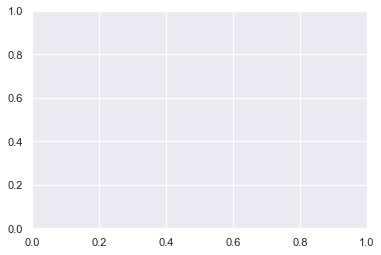

In [1011]:
plt.plot(CNN1d.loss,label='CNN1d.loss', color = 'blue')
# plt.plot(slr.val_loss,label='slr.val_loss', color = 'orange')
plt.grid(True)                                 # グリッド線を表示
plt.legend()
"""
過学習対策にtrainloss曲線もplotしておく？
"""

In [ ]:

"""
以下Sprint１０
"""
class ScratchDeepNeuralNetrowkClassifier():
    """
    Deep Neural Netrowk 分類器

    Parameters
    ------    

    Attributes
    ----------
    """

    def __init__(self, max_iter=5,
                 lr=0.01, sigma = 0.01,
                 verbose = True):
        """
        self.sigma : ガウス分布の標準偏差
        self.lr : 学習率
        self.iter : 学習回数
        """
        self.iter = max_iter
        self.lr = lr
        self.sigma = sigma
        self.verbose = verbose
    
    def loss_func(self,y,y_pred_proba):
        sigma_c = np.sum(y * np.log(y_pred_proba), axis = 1) 
        #batch_size方向に平均
        return -np.mean(sigma_c)
    
    def fit(self, X, y,
            sigma = 0.01,n_nodes1 = 400,n_nodes2 = 200,
            n_output = 10, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        
        # self.n_nodes1 : 1層目のノード数
        # self.n_nodes2 : 2層目のノード数
        # self.n_output : 出力層のノード数

        """
        self.n_features = X.shape[1]
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        
        optimizer = SGD(self.lr) #更新方法選択
        
        self.FC1 = FC(self.n_features, self.n_nodes1,
                      SimpleInitializer(weight_type='xav',sigma = self.sigma),optimizer)
        self.activation1 = Sigmoid()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, 
                      SimpleInitializer(weight_type='xav',sigma = self.sigma),optimizer)
        self.activation2 = Sigmoid()
        self.FC3 = FC(self.n_nodes2, self.n_output, 
                      SimpleInitializer(weight_type='xav',sigma = self.sigma),optimizer)
        self.activation3 = Softmax()
        self.loss = None
        
        for n in range(self.iter): #何回回そう？ MNISTなら50回ほどで試す
            get_mini_batch = GetMiniBatch(X_train,
                                          y_train_one_hot,
                                          batch_size=20)
            for mini_X_train, mini_y_train in get_mini_batch:
            # このfor文内でミニバッチが使える
                #W,B = FC内 FCX.W, FCX.B (Xは1,2,...)
                A1 = self.FC1.forward(mini_X_train) #(batch_size, n_nodes1)
                Z1 = self.activation1.forward(A1) #(batch_size, n_nodes1)
                A2 = self.FC2.forward(Z1) #(batch_size, n_nodes2)
                Z2 = self.activation2.forward(A2) #(batch_size, n_nodes2)
                A3 = self.FC3.forward(Z2) #(batch_size, n_output)
                Z3 = self.activation3.forward(A3) #(batch_size, n_output)                
                
                dA3 = self.activation3.backward(Z3, mini_y_train) #(batch_size, n_output)
                # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3) #(batch_size, n_nodes2)
                dA2 = self.activation2.backward(dZ2) #(batch_size, n_nodes2)
                dZ1 = self.FC2.backward(dA2) #(batch_size, n_nodes1)
                dA1 = self.activation1.backward(dZ1) #(batch_size, n_nodes1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
            
            A1 = self.FC1.forward(X) #(sample_size, n_nodes1)
            Z1 = self.activation1.forward(A1) #(sample_size, n_nodes1)
            A2 = self.FC2.forward(Z1) #(sample_size, n_nodes2)
            Z2 = self.activation2.forward(A2) #(sample_size, n_nodes2)
            A3 = self.FC3.forward(Z2) #(sample_size, n_output)
            Z3 = self.activation3.forward(A3) #(sample_size, n_output)
            y_pred_proba = Z3
            loss = self.loss_func(y,y_pred_proba)
            self.loss = np.append(self.loss,loss)
            
        self.loss = np.delete(self.loss, 0)
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print("self.loss.shape",self.loss.shape)
                
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        A1 = self.FC1.forward(X) #(n_samples, n_nodes1)
        Z1 = self.activation1.forward(A1) #(n_samples, n_nodes1)
        A2 = self.FC2.forward(Z1) #(n_samples, n_nodes2)
        Z2 = self.activation2.forward(A2) #(n_samples, n_nodes2)
        A3 = self.FC3.forward(Z2) #(n_samples, n_output)
        Z3 = self.activation3.forward(A3) #(n_samples, n_output)

        y_pred_proba = np.argmax(Z3,axis=1)
        return y_pred_proba